In [1]:
import numpy as np
import pandas as pd
import os
import textwrap
import re 
import sklearn.linear_model
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer ,TfidfVectorizer
from sklearn.metrics import make_scorer, roc_auc_score ,confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping
from skorch.dataset import ValidSplit
from sklearn.preprocessing import StandardScaler

In [2]:
data_dir = 'data_readinglevel'
x_train_df = pd.read_csv(os.path.join(data_dir, 'x_train.csv'))
y_train_df = pd.read_csv(os.path.join(data_dir, 'y_train.csv'))
y_train_df['stage_encoded'] = y_train_df['Coarse Label'].map({'Key Stage 2-3': 0, 'Key Stage 4-5': 1})
y_train_clean = y_train_df['stage_encoded'].values
N, n_cols = x_train_df.shape
#print("Shape of x_train_df: (%d, %d)" % (N, n_cols))
#print("Shape of y_train_df: %s" % str(y_train_df.shape))
print(x_train_df.shape)

def load_arr_from_npz(npz_path):
    ''' Load array from npz compressed file given path

    Returns
    -------
    arr : numpy ndarray
    '''
    npz_file_obj = np.load(npz_path)
    arr = npz_file_obj.f.arr_0.copy() # Rely on default name from np.savez
    npz_file_obj.close()
    return arr

xBERT_train_NH = load_arr_from_npz(os.path.join(
        data_dir, 'x_train_BERT_embeddings.npz'))

assert len(xBERT_train_NH) == len(x_train_df)

(5557, 32)


In [3]:
#tr_text_list = x_train_df['text'].values

def custom_tokenizer(text):
    return re.findall(r"\w+|[^\w\s]", text)


# Set random seeds for reproducibility
random_state = 1543


# Identify categorical columns
# categorical_cols = ['author', 'title']
# print(x_train_df.columns)
# # One-Hot Encode 'author' and 'title'
# categorical_data = x_train_df.loc[:, categorical_cols]  # Explicitly select columns as DataFrame
# # One-Hot Encode 'author' and 'title'
# encoder = OneHotEncoder(handle_unknown='ignore')
# one_hot_encoded = encoder.fit_transform(categorical_data)
# one_hot_encoded = one_hot_encoded.toarray()

# print(type(one_hot_encoded))
# print(f"One-hot encoded shape: {one_hot_encoded.shape}")

tr_text_list = x_train_df['text'].values
x_train_df = x_train_df.drop(columns=['author','title','passage_id','text'])

# Convert BERT embeddings to DataFrame
bert_df = pd.DataFrame(xBERT_train_NH, columns=[f'bert_{i}' for i in range(xBERT_train_NH.shape[1])])
bert_array = bert_df.to_numpy()
print(f"Bert array has shape: {bert_array.shape }")
print(f"x_train array has shape: {x_train_df.to_numpy().shape }")

# Concatenate all features
X_train_final_np = np.hstack((x_train_df.to_numpy(),bert_array))
#X_train_final_np = np.hstack((one_hot_encoded,x_train_df.to_numpy(),bert_array))

# Print final shape
print(f"Final feature matrix shape: {X_train_final_np.shape}")

y_train_clean = np.array(y_train_clean)
X_text_train, X_text_test,X_train_val, X_test, y_train_val, y_test = train_test_split(tr_text_list, X_train_final_np, y_train_clean, test_size=0.1, random_state=1543, stratify=y_train_clean)


Bert array has shape: (5557, 768)
x_train array has shape: (5557, 28)
Final feature matrix shape: (5557, 796)


In [4]:
vectorizer = TfidfVectorizer(min_df=2, max_df=0.8, ngram_range=(1,2), 
                              stop_words=None, token_pattern=r'(?u)\\b\\w{2,}\\b', 
                              lowercase=False,norm='l2',tokenizer=custom_tokenizer,preprocessor=None,analyzer='word')
X_train_tfidf = vectorizer.fit_transform(X_text_train)
X_test_tfidf = vectorizer.transform(X_text_test)
# Scale numerical features (optional but recommended)
# scaler = StandardScaler()
# X_train_val = scaler.fit_transform(X_train_val)
# X_test = scaler.transform(X_test)
# Convert TF-IDF sparse matrices to dense arrays
X_train_tfidf_dense = X_train_tfidf.toarray()
X_test_tfidf_dense = X_test_tfidf.toarray()
# Combine TF-IDF and numerical features
X_train_val = np.concatenate([X_train_tfidf_dense, X_train_val], axis=1)
X_test = np.concatenate([X_test_tfidf_dense, X_test], axis=1)
print(X_train_val.shape)

c:\Users\ningn\anaconda3\envs\cs135_25s_env\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(5001, 59069)


In [25]:
from torch.optim.lr_scheduler import StepLR
from skorch.callbacks import LRScheduler
from torch.optim.lr_scheduler import ExponentialLR
class MLP(nn.Module):
    def __init__(self, input_size, hidden_units, activation='relu'):
        super().__init__()
        self.layers = nn.ModuleList()
        prev_units = input_size
        activation_class = {
            'relu': nn.ReLU,
            'tanh': nn.Tanh,
            'logistic': nn.Sigmoid
        }[activation]
        for units in hidden_units:
            self.layers.append(nn.Linear(prev_units, units))
            self.layers.append(activation_class())
            prev_units = units
        self.output_layer = nn.Linear(prev_units, 1)
    
    def forward(self, X):
        for layer in self.layers:
            X = layer(X)
        logits = self.output_layer(X)
        return logits.squeeze(-1)
net = NeuralNetClassifier(
    module=MLP,
    module__input_size=X_train_val.shape[1],
    module__hidden_units=(64,),
    module__activation='relu',
    optimizer=optim.Adam,
    criterion=nn.BCEWithLogitsLoss,
    max_epochs=200,
    batch_size=32,
    callbacks=[
        EarlyStopping(patience=10),
        # LRScheduler(
        #     policy=ExponentialLR,
        #     gamma=0.95
        # )
        # LRScheduler(
        #     policy=StepLR,
        #     step_size = 10,
        #     gamma=0.3
        # )
    ],
    train_split=ValidSplit(0.1, stratified=True),
    device='cuda' if torch.cuda.is_available() else 'cpu',
    verbose=1
)
param_grid = {
    'module__hidden_units': [(64,), (64, 32), (32, 16), (64, 32,16),  (128, 128),(256, 128, 64)],
    'module__activation': ['relu', 'tanh', 'logistic'],
    'optimizer__weight_decay': [1e-6,1e-5,1e-4, 0.001, 0.01],
    'optimizer__lr': [0.00005, 0.0001, 0.0005, 0.001, 0.01],
    'batch_size': [32, 64, 128,256],
}

In [26]:
random_search = RandomizedSearchCV(
    net,
    param_distributions=param_grid,
    n_iter=100,
    refit=True,
    scoring='roc_auc',
    cv=5,
    verbose=3,
    random_state=random_state,
    n_jobs=1,  # skorch doesn't support parallel jobs
    return_train_score=True, 
)

# Convert data to float32 for PyTorch
X_train_val_float = X_train_val.astype(np.float32)
y_train_val_float = y_train_val.astype(np.float32)

random_search.fit(X_train_val_float, y_train_val_float)
best_model = random_search.best_estimator_
X_test_float = X_test.astype(np.float32)

# Predict probabilities
y_test_probs = best_model.predict_proba(X_test_float)[:, 1]

# Calculate metrics
best_test_scores = roc_auc_score(y_test, y_test_probs)
predicted_labels = np.where(y_test_probs >= 0.5, 1, 0)
cm = confusion_matrix(y_test, predicted_labels)
cm_df = pd.DataFrame(cm, 
                     index=['Actual 0', 'Actual 1'], 
                     columns=['Predicted 0', 'Predicted 1'])
print(cm_df)
print(f"Test Set ROC AUC Score: {best_test_scores:.4f}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6717       0.6500        0.6384  0.9412
      2        0.6190       0.6850        0.5872  0.6508
      3        0.5773       0.7025        0.5635  0.6583
      4        0.5594       0.7000        0.5593  0.6164
      5        0.5492       0.7175        0.5502  0.5946
      6        0.5384       0.7125        0.5514  0.5940
      7        0.5241       0.7200        0.5414  0.6049
      8        0.5017       0.7475        0.5323  0.6120
      9        0.4762       0.6950        0.6131  0.5901
     10        0.4612       0.7400        0.5220  0.5853
     11        0.3879       0.7075        0.6060  0.5922
     12        0.3733       0.5925        0.8123  0.6647
     13        0.3856       0.6775        0.7467  0.6961
     14        0.3104       0.7525        0.5673  0.5801
     15        0.2149    

In [27]:
best_model_overall = random_search.best_estimator_
print(best_model_overall.get_params())

x_test_df = pd.read_csv(os.path.join(data_dir, 'x_test.csv'))
xBERT_test_NH = load_arr_from_npz(os.path.join(data_dir, 'x_test_BERT_embeddings.npz'))


#categorical_data_test = x_test_df.loc[:, ['author', 'title']]
#one_hot_encoded_test = encoder.transform(categorical_data_test).toarray()
test_text_list = x_test_df['text'].values
x_test_clean = x_test_df.drop(columns=['author','title','passage_id','text']).to_numpy()

bert_test_df = pd.DataFrame(xBERT_test_NH, columns=[f'bert_{i}' for i in range(xBERT_test_NH.shape[1])])
X_test_final = np.hstack((
   # one_hot_encoded_test,
    x_test_clean,
    bert_test_df.to_numpy()
)).astype(np.float32) 
X_test_tfidf = vectorizer.transform(test_text_list).astype(np.float32)
X_test_tfidf_dense = X_test_tfidf.toarray()

X_test_final_np = np.concatenate([X_test_tfidf_dense, X_test_final], axis=1)
print(X_test_final_np.shape)
yproba_N2 = best_model_overall.predict_proba(X_test_final_np)
print("Class probabilities (first 5):\n", yproba_N2[:5])

y_proba_N1 = yproba_N2[:, 1]
print("Class 1 probabilities (first 5):", y_proba_N1[:5])
print("Probability array shape:", y_proba_N1.shape)

np.savetxt("yproba1_test.txt", y_proba_N1, fmt="%.6f")
loaded_probs = np.loadtxt('yproba1_test.txt')
print("Loaded probabilities shape:", loaded_probs.shape)

{'module': <class '__main__.MLP'>, 'criterion': <class 'torch.nn.modules.loss.BCEWithLogitsLoss'>, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.01, 'max_epochs': 200, 'batch_size': 256, 'iterator_train': <class 'torch.utils.data.dataloader.DataLoader'>, 'iterator_valid': <class 'torch.utils.data.dataloader.DataLoader'>, 'dataset': <class 'skorch.dataset.Dataset'>, 'train_split': <skorch.dataset.ValidSplit object at 0x0000020D5C53D910>, 'callbacks': [<skorch.callbacks.training.EarlyStopping object at 0x0000020BCA2FEE90>], 'predict_nonlinearity': 'auto', 'warm_start': False, 'verbose': 1, 'device': 'cpu', 'compile': False, 'use_caching': 'auto', 'torch_load_kwargs': None, '_params_to_validate': {'module__activation', 'optimizer__lr', 'module__hidden_units', 'module__input_size', 'optimizer__weight_decay'}, 'module__input_size': 59069, 'module__hidden_units': (64, 32), 'module__activation': 'tanh', 'classes': None, 'optimizer__weight_decay': 1e-06, 'optimizer__lr': 0.001, 'callba

In [28]:
import pandas as pd


results_df = pd.DataFrame(random_search.cv_results_)
print(results_df.columns)
param_columns = [col for col in results_df.columns if col.startswith("param_")]
for col in param_columns:

    results_df[col] = results_df[col].apply(
        lambda x: 'None' if x is None else str(x) 
    )

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_optimizer__weight_decay', 'param_optimizer__lr',
       'param_module__hidden_units', 'param_module__activation',
       'param_batch_size', 'params', 'split0_test_score', 'split1_test_score',
       'split2_test_score', 'split3_test_score', 'split4_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score',
       'split0_train_score', 'split1_train_score', 'split2_train_score',
       'split3_train_score', 'split4_train_score', 'mean_train_score',
       'std_train_score'],
      dtype='object')


optimizer__weight_decay


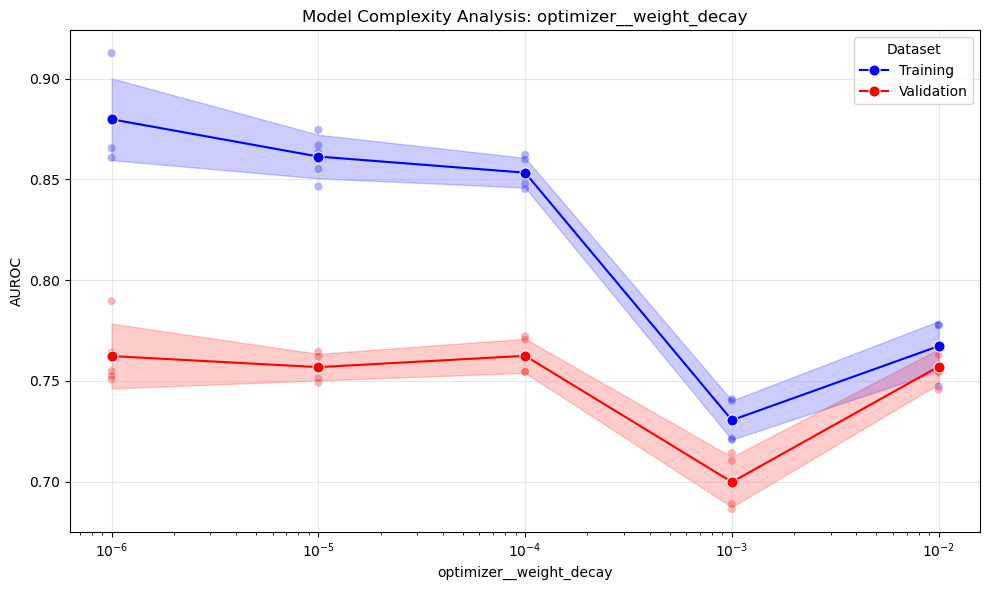

optimizer__lr


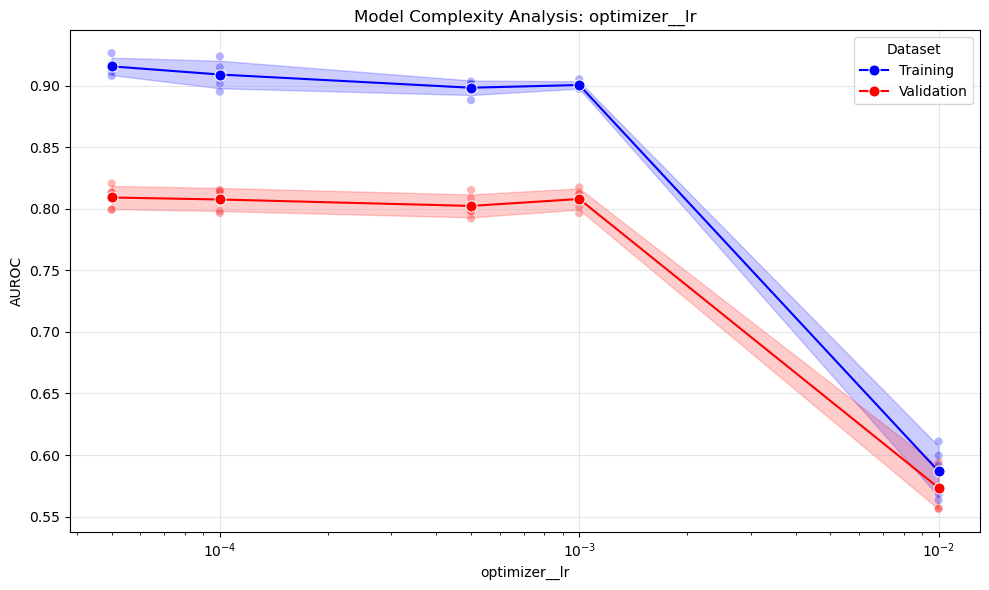

module__hidden_units


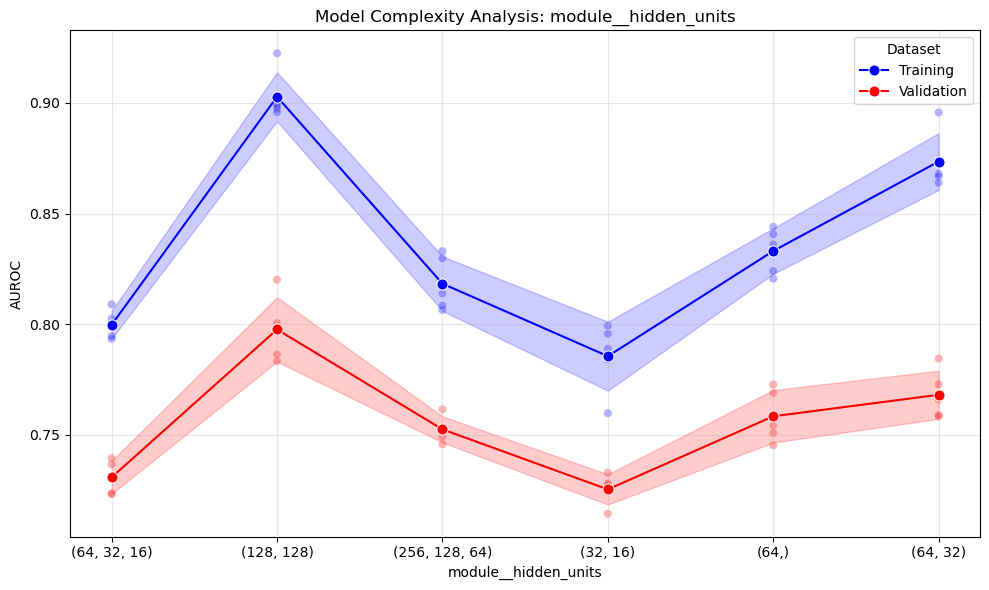

module__activation


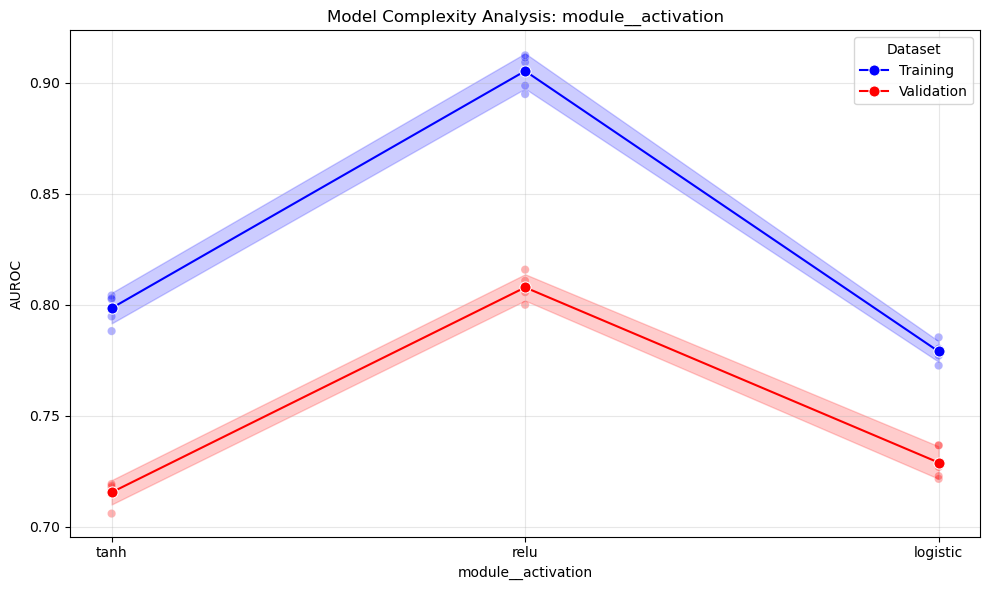

batch_size


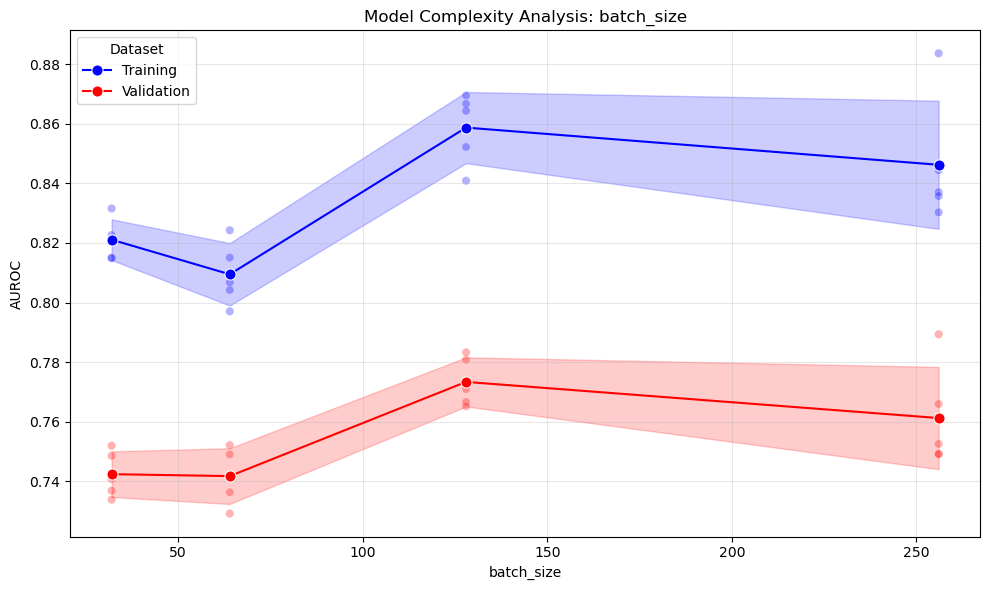

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_hyperparam_complexity_curves(results_df, param_name, 
                                    metric_name="mean_test_score",
                                    cv_folds=5):
    

    param_values = results_df[f"param_{param_name}"]
    param_col = f"param_{param_name}"
    

    cv_metrics = []
    for split in range(cv_folds):
        cv_metrics.extend([
            (f"split{split}_train_score", "Training"),
            (f"split{split}_test_score", "Validation")
        ])
    plot_data = []
    for metric_col, metric_type in cv_metrics:
        for para in results_df[param_col].unique():
            if param_name == 'module__hidden_units':
                para = str(para)
            plot_data.append({
                param_name: para,
                "Score": np.mean(results_df.loc[results_df[param_col] == para, metric_col]),
                "Type": metric_type
            })
    plot_df = pd.DataFrame(plot_data)
    if param_name == 'batch_size' or param_name == 'optimizer__lr' or param_name == 'optimizer__weight_decay':
        plot_df[param_name] = pd.to_numeric(plot_df[param_name])
    
    plt.figure(figsize=(10, 6))

    sns.lineplot(
        data=plot_df, 
        x=param_name, 
        y="Score", 
        hue="Type",
        errorbar='sd',  
        err_style="band",  
        estimator=np.mean,
        marker="o",
        markersize=8,
        palette={"Training": "blue", "Validation": "red"}
    )
    

    sns.scatterplot(
        data=plot_df,
        x=param_name, 
        y="Score",
        hue="Type",
        alpha=0.3,
        palette={"Training": "blue", "Validation": "red"},
        legend=False
    )
    

    plt.xlabel(param_name)
    if param_name == 'optimizer__weight_decay' or param_name == 'optimizer__lr':
        plt.xscale('log')
        #plt.xticks(rotation=45)
        
    plt.ylabel("AUROC")
    plt.title(f"Model Complexity Analysis: {param_name}")
    plt.legend(title="Dataset")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


for param in [col.replace("param_", "") for col in param_columns]:
    print(param)
    plot_hyperparam_complexity_curves(
        results_df, 
        param,
        cv_folds=5
    )